# Modeling the Worst: A Zombie and Ebola outbreak
Jahad Ahmed Hamidi, Ruhan Reza, Stian Salte

## Abstract

## Introduction

## Exercise 5 -  Ebola epidemic in West Africa

### Task 1

We start by plotting the outbreak data of ebola cases in Guinea, Liberia and Sierra Leone

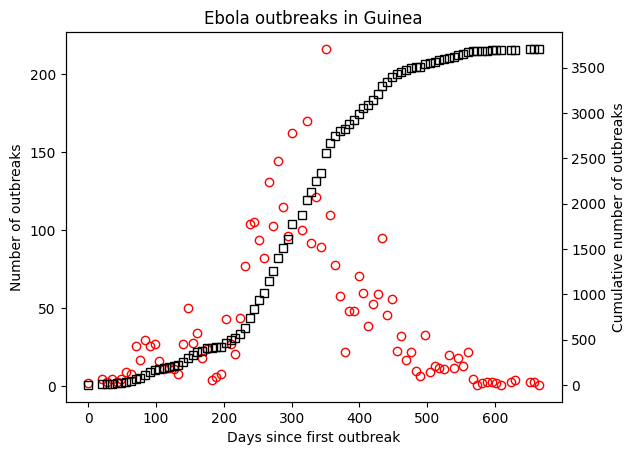

In [133]:
# Making a figure for Guinea
import pandas as pd
import matplotlib.pyplot as plt

def plot_outbreak(file, country):
    df = pd.read_csv(file, sep="\t")

    df["Cumulative Cases"] = df["NumOutbreaks"].cumsum()

    _, ax1 = plt.subplots()
    plt.title(f"Ebola outbreaks in {country}")
    ax1.set_xlabel("Days since first outbreak")
    ax1.set_ylabel("Number of outbreaks")
    ax2 = ax1.twinx()
    ax2.set_ylabel("Cumulative number of outbreaks")
    

    ax1.plot(df["Days"], df["NumOutbreaks"], marker="o", linestyle="None", fillstyle="none", color="red")
    ax2.plot(df["Days"], df["Cumulative Cases"], marker="s", linestyle="None", fillstyle="none", color="black")

plot_outbreak("./data/ebola_cases_guinea.dat", "Guinea")


We do the same for Liberia:

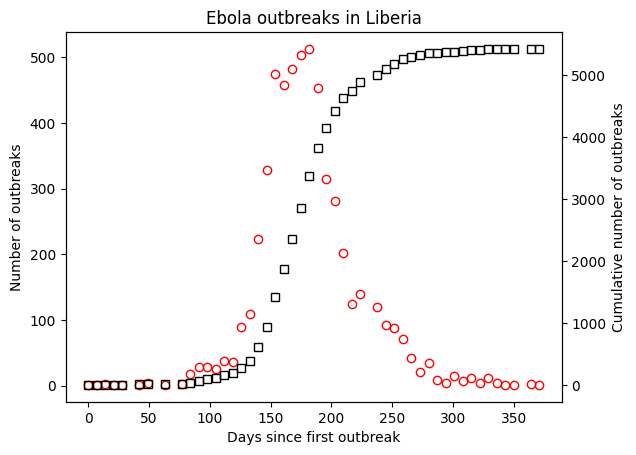

In [134]:
#Making a figure for Liberia
plot_outbreak("./data/ebola_cases_liberia.dat", "Liberia")

And finally for Sierra Leone:

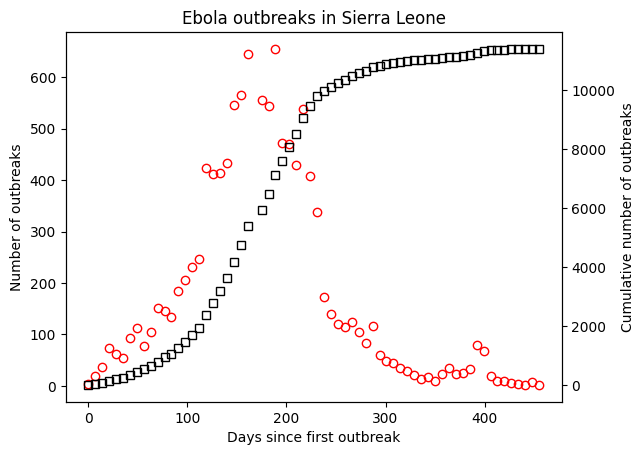

In [135]:
#Making a figure for Sierra Leone
plot_outbreak("./data/ebola_cases_sierra_leone.dat", "Sierra Leone")

## Task 2

In this task we used the SEZR-model to try to simulate the real world data we used in task 1. The equations for the model used are:

$$
\frac{S(t)}{dt} = -\beta(t) \times \frac{S(t)Z(t)}{N}
$$ 

$$
\frac{E(t)}{dt} = \beta(t) \times \frac{S(t)Z(t)}{N} - \sigma E(t)
$$ 

$$
\frac{Z(t)}{dt} = \sigma E(t) - \gamma Z(t)
$$ 

$$
\frac{R(t)}{dt} = \gamma Z(t)
$$ 

Seeing as the estimated infectious period for Ebola is one week we can determine $1 / \gamma = 7$, and with the latency period being 9.7 days we determine $1 / \sigma = 9.7$
We also assume a static population of $N = 10^7$  

With the established equations and parameters we implement the system as a function (ebola) in python and along with an ode solver we can create a simulated model of the ebola outbreak:

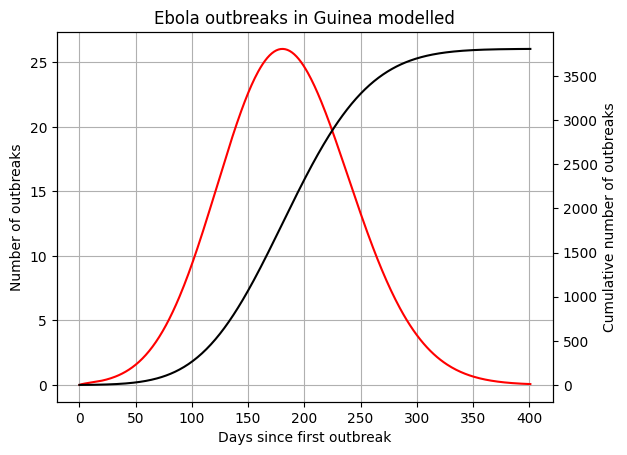

In [152]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

df = pd.read_csv("./data/ebola_cases_guinea.dat", sep="\t")

df["Cumulative Cases"] = df["NumOutbreaks"].cumsum()

def step(dt, f, t,c_old, *args, **kwargs):
    k1 = np.array(dt*f(t, c_old, *args, **kwargs))
    return dt*f(t+dt*0.5, c_old + 0.5*k1, *args, **kwargs)

def ode_solver(t0, t_final, c0, dt, f, *args, **kwargs):
    """
    ODE solver using RK2

    Input
    -----
    t0: float, starting time
    t_final: float, end time
    c0: float, initial condition
    dt: float, step size
    f: ode function

    Output
    -----
    t, c
    """
    N = int(t_final/dt) + 1  
    c = []
    t = []
    c.append(c0) 
    t.append(t0)
    for i in range(N):
        c_old = c[-1]
        c_old = np.array(c_old)
        t_old = t[-1]
        c.append(c_old + step(dt, f, t_old, c_old, *args, **kwargs)) 
        t.append(t[-1]+dt)
    return np.array(t), np.array(c)

def ebola(t, c, beta0, lam, sigma=1/9.7, gamma=1/7, N=1e7):
    """
    SEZR model for Ebola

    Input
    -----
    t: float, time
    c: array, [S, E, Z, R]
    beta0: float, initial transmission rate
    lam: float, decay rate of transmission
    sigma: float, rate of progression from exposed to infectious
    gamma: float, recovery/removed rate
    N: float, total population
    
    """
    S, E, Z, R = c
    beta_t = beta0 * np.exp(-lam * t)
    dS = -beta_t * S * Z / N
    dE = beta_t * S * Z / N - sigma * E
    dZ = sigma * E - gamma * Z
    dR = gamma * Z
    return np.array([dS, dE, dZ, dR])

t0 = 0
t_final = 400
dt = 1
# Experimenting with theese parameters
beta0 = 0.351
lam = 0.0049

t, c = ode_solver(t0=t0, t_final=t_final, c0=[1e7, 0, 1, 0], dt=dt, f=ebola, beta0=beta0, lam=lam)

S, E, Z, R = c.T # Transpose and assign to each compartment
cumulative_cases = Z + R
new_outbreaks = (1/9.7) * E


_, ax1 = plt.subplots()
plt.title(f"Ebola outbreaks in Guinea modelled")
ax1.set_xlabel("Days since first outbreak")
ax1.set_ylabel("Number of outbreaks")
ax2 = ax1.twinx()
ax2.set_ylabel("Cumulative number of outbreaks")
ax1.grid()

ax1.plot(t, new_outbreaks, fillstyle="none", color="red")
ax2.plot(t, cumulative_cases, fillstyle="none", color="black")

Using the model we just created we compare the data to the actual cases of Guinea to check how good of a model it is, first we compared the cumulative cases:

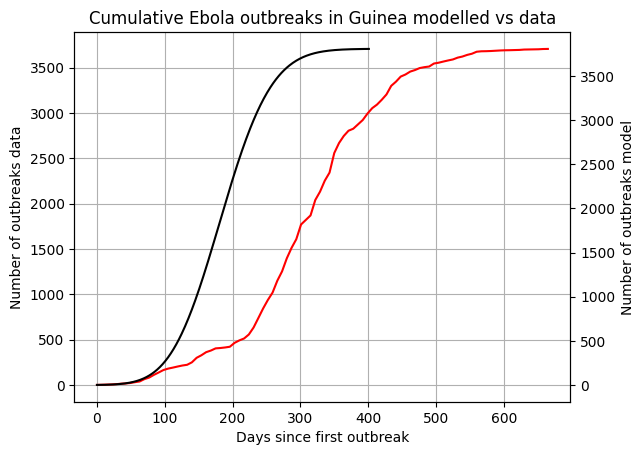

In [137]:
_, ax1 = plt.subplots()
plt.title(f"Cumulative Ebola outbreaks in Guinea modelled vs data")
ax1.set_xlabel("Days since first outbreak")
ax1.set_ylabel("Number of outbreaks data")
ax2 = ax1.twinx()
ax2.set_ylabel("Number of outbreaks model")


ax1.plot(df["Days"], df["Cumulative Cases"], fillstyle="none", color="red")
ax2.plot(t, cumulative_cases, fillstyle="none", color="black")
ax1.grid()

The comparsion between model and data shows that the model fits the cumulative number of outbreaks quite well. However, we see that the model starts growing much earlier than the data. We will explore this by comparing number of new cases:

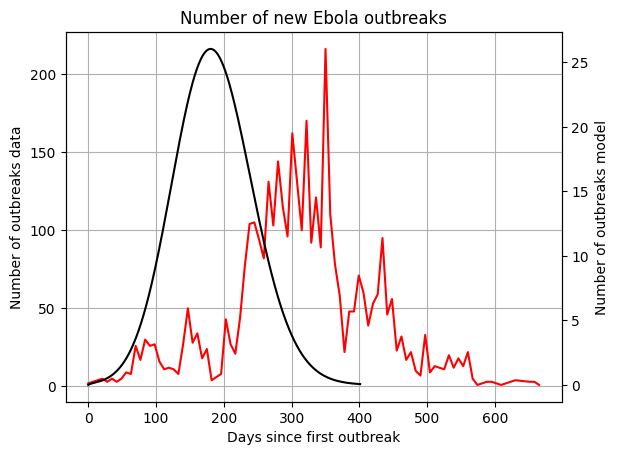

In [138]:
_, ax1 = plt.subplots()
plt.title(f"Number of new Ebola outbreaks")
ax1.set_xlabel("Days since first outbreak")
ax1.set_ylabel("Number of outbreaks data")
ax2 = ax1.twinx()
ax2.set_ylabel("Number of outbreaks model")
ax1.grid()


ax1.plot(df["Days"], df["NumOutbreaks"], fillstyle="none", color="red")
ax2.plot(t, new_outbreaks, fillstyle="none", color="black")

We observe from the comparison between the model and data that the number of new outbreaks are vastly different. This is most likely due to the reporting of new cases in the data happens every week, while the model records new cases each day.

For the model up to this point we have used values for beta0 = 0.351 lam = 0.0049 as they were deemed to be the best fit. We also tried other values for these parameters and compared them to eachother:


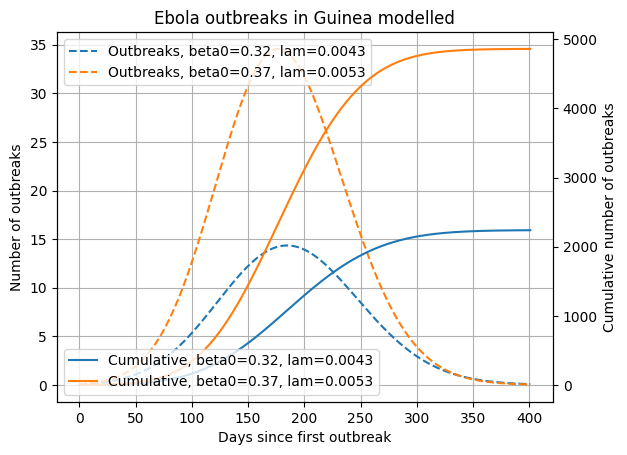

In [147]:
t, c = ode_solver(t0=t0, t_final=t_final, c0=[1e7, 0, 1, 0], dt=dt, f=ebola, beta0=0.32, lam=0.0043)

beta0_lam_set = [(0.32, 0.0043), (0.37, 0.0053)]

_, ax1 = plt.subplots()
plt.title(f"Ebola outbreaks in Guinea modelled")
ax1.set_xlabel("Days since first outbreak")
ax1.set_ylabel("Number of outbreaks")
ax2 = ax1.twinx()
ax2.set_ylabel("Cumulative number of outbreaks")
ax1.grid()

for beta0, lam in beta0_lam_set:
    t, c = ode_solver(t0=t0, t_final=t_final, c0=[1e7, 0, 1, 0], dt=dt, f=ebola, beta0=beta0, lam=lam)
    S, E, Z, R = c.T
    cumulative_cases = Z + R
    new_outbreaks = (1/9.7) * E

    ax1.plot(t, new_outbreaks, label=f"Outbreaks, beta0={beta0}, lam={lam}", fillstyle="none", linestyle="--")
    ax2.plot(t, cumulative_cases, label=f"Cumulative, beta0={beta0}, lam={lam}")

ax1.legend(loc="upper left")
ax2.legend(loc="lower left")





This figure shows how sensitive the model is to small changes to initial transmission rate and decay rate of transmission. Small changes creates big differences in both the cumulative and daily outbreak numbers.

## Conclusion & Discussion

## Self-reflections